# Introduction

In [1250]:
import sys
!{sys.executable} -m pip install tensorflow_text tensorflow_hub tensorflow transformers
!{sys.executable} -m pip install -q tf-models-official==2.7.0

/Users/theophile/.zshenv:6: no such file or directory: 2
/Users/theophile/.zshenv:7: no such file or directory: 2
/Users/theophile/.zshenv:8: no such file or directory: 2
/Users/theophile/.zshenv:9: no such file or directory: 2
/Users/theophile/.zshenv:11: no such file or directory: 2
/Users/theophile/.zshenv:12: no such file or directory: 2
/Users/theophile/.zshenv:15: no such file or directory: 2


# Data Exploration

In [1]:
import numpy as np
import pandas as pd

import nltk
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('punkt')
from nltk.corpus import stopwords 
from nltk.stem import WordNetLemmatizer

from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import cross_validate
from sklearn import feature_selection
from sklearn.preprocessing import OneHotEncoder, MinMaxScaler
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier

import scipy.stats as stats
from scipy.sparse import hstack

import gensim.downloader as api

import string
from string import punctuation

from tensorflow.keras import layers, models
from tensorflow.keras import callbacks
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.optimizers.schedules import ExponentialDecay
from tensorflow.keras.optimizers import Adam
from tensorflow import keras
import tensorflow as tf

import tensorflow_hub as hub
import tensorflow_text as text

from official.nlp import optimization 

import matplotlib.pyplot as plt
import seaborn as sns

import transformers

import warnings
warnings.filterwarnings("ignore")

ModuleNotFoundError: No module named 'nltk'

## Useful functions

In [518]:
# Plots the disribution of a variable colored by value of the target
def kde_target(tar_name, var_name, df):
    
    # Calculate the correlation coefficient between the new variable and the target
    corr = df[tar_name].corr(df[var_name])
    
    # Calculate medians for survived vs not survived
    avg_not_survived = df.loc[df[tar_name] == 0, var_name].median()
    avg_survived = df.loc[df[tar_name] == 1, var_name].median()
    
    plt.figure(figsize = (12, 6))
    
    # Plot the distribution for target == 0 and target == 1
    #sns.kdeplot(df.loc[df[tar_name] == 0, var_name], label = '%s == 0' % (tar_name))
    #sns.kdeplot(df.loc[df[tar_name] == 1, var_name], label = '%s == 1' % (tar_name))
    
    sns.displot(data=train, x=var_name, hue=tar_name, kind="kde", height=6, aspect=2)
    
    # label the plot
    plt.xlabel(var_name); plt.ylabel('Density'); plt.title('%s Distribution' % var_name)
    plt.legend();
    
    # print out the correlation
    print('The correlation between %s and %s is %0.4f' % (var_name, tar_name, corr))
    # Print out average values
    print('Median value for a person does not survived = %0.4f' % avg_not_survived)
    print('Median value for a person does survived =     %0.4f' % avg_survived)
    

In [519]:
# Computes Cramer's V
def cramer_v(chi2, dof, n):
    v = np.sqrt(chi2/(n*dof))
    return v

In [520]:
# Visualizes ROC AUC curve
def visualize_roc_auc_curve(model, model_name,X_test,y_test):
    pred_prob = model.predict_proba(X_test)
    fpr, tpr, thresh = roc_curve(y_test, pred_prob[:,1], pos_label=1)

    random_probs = [0 for i in range(len(y_test))]
    p_fpr, p_tpr, _ = roc_curve(y_test, random_probs, pos_label=1)  # tpr = fpr

    score = roc_auc_score(y_test, pred_prob[:,1])
    print("ROC AUC Score:", score)

    plt.figure(figsize=(10,8))
    plt.plot(fpr, tpr, linestyle='--',color='orange')
    plt.plot(p_fpr, p_tpr, linestyle='--', color='blue')

    plt.title(f'{model_name} ROC curve', size=15)
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive rate')
    plt.show()

In [521]:
# Visualize features importance
def f_importances(model, model_name, X):
    f_imp = pd.DataFrame({"Feature Importances": model.feature_importances_}, index=X.columns)

    plt.figure(figsize=(12,8))
    sns.barplot(x=f_imp["Feature Importances"], y=f_imp.index)
    plt.title(f"{model_name} Feature Importances", size=15)
    plt.show()

In [522]:
def remove_punctuation(text):
    return (''.join([x for x in text if x not in punctuation]))

In [523]:
stop_words = set(stopwords.words('english'))

In [524]:
def remove_stop_words(text):
    list_text = nltk.word_tokenize(text)
    return ' '.join([word for word in list_text if word not in stop_words])

In [525]:
def lowercase (text): 
    return text.lower() 

In [526]:
def lemma(text):
    lemmatizer = WordNetLemmatizer() # Initiate lemmatizer
    list_text = nltk.word_tokenize(text)
    lemmatized = [lemmatizer.lemmatize(word) for word in list_text] # Lemmatize
    lemmatized_string = " ".join(lemmatized)
    return lemmatized_string

In [527]:
def remove_word_containing(text,subtext):
    list_text = nltk.word_tokenize(text)
    return (" ".join([word for word in list_text if subtext not in word]))

In [567]:
# Function to convert a sentence (list of words) into a matrix representing the words in the embedding space
def embed_sentence_with_TF(word2vec, sentence):
    embedded_sentence = []
    for word in sentence:
        if word in word2vec:
            embedded_sentence.append(word2vec[word])
        
    return np.array(embedded_sentence)

In [566]:
# Function that converts a list of sentences into a list of matrices
def embedding(word2vec, sentences):
    embed = []
    
    for sentence in sentences:
        embedded_sentence = embed_sentence_with_TF(word2vec, sentence)
        embed.append(embedded_sentence)
        
    return embed


## Global Analysis

In [ ]:
train_raw = pd.read_csv("train.csv", sep = ',')
test_raw = pd.read_csv("test.csv", sep = ',')
target_test = pd.read_csv("sample_submission.csv",sep = ',')

### Train set

In [529]:
train_raw.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7613 entries, 0 to 7612
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   id        7613 non-null   int64 
 1   keyword   7552 non-null   object
 2   location  5080 non-null   object
 3   text      7613 non-null   object
 4   target    7613 non-null   int64 
dtypes: int64(2), object(3)
memory usage: 297.5+ KB


In [530]:
# Count duplicated values
train_raw.duplicated().value_counts()

False    7613
dtype: int64

In the train set, there are:
- 5 columns: **4** possible features (id, keyword, location and text) and **1** target (target)
- **7613** entries
- **keyword** and **location** have NaN values
- There is no duplicated values

### Test set

In [531]:
test_raw.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3263 entries, 0 to 3262
Data columns (total 4 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   id        3263 non-null   int64 
 1   keyword   3237 non-null   object
 2   location  2158 non-null   object
 3   text      3263 non-null   object
dtypes: int64(1), object(3)
memory usage: 102.1+ KB


In [532]:
test_raw.duplicated().value_counts()

False    3263
dtype: int64

In the test set, there are:
- 4 columns that are only possible features
- **3263** entries
- **keyword** and **location** have NaN values
- There is no duplicated values

## Exploration of keyword

In [533]:
# Proportion of non null values
print(f"There are {len(train_raw[~train_raw['keyword'].isna()])/len(train_raw)*100:.02f}% of non null values for keyword")

There are 99.20% of non null values for keyword


In [534]:
# Count of unique values
print(f"There are {train_raw[~train_raw['keyword'].isna()]['keyword'].nunique()} unique values")

There are 221 unique values


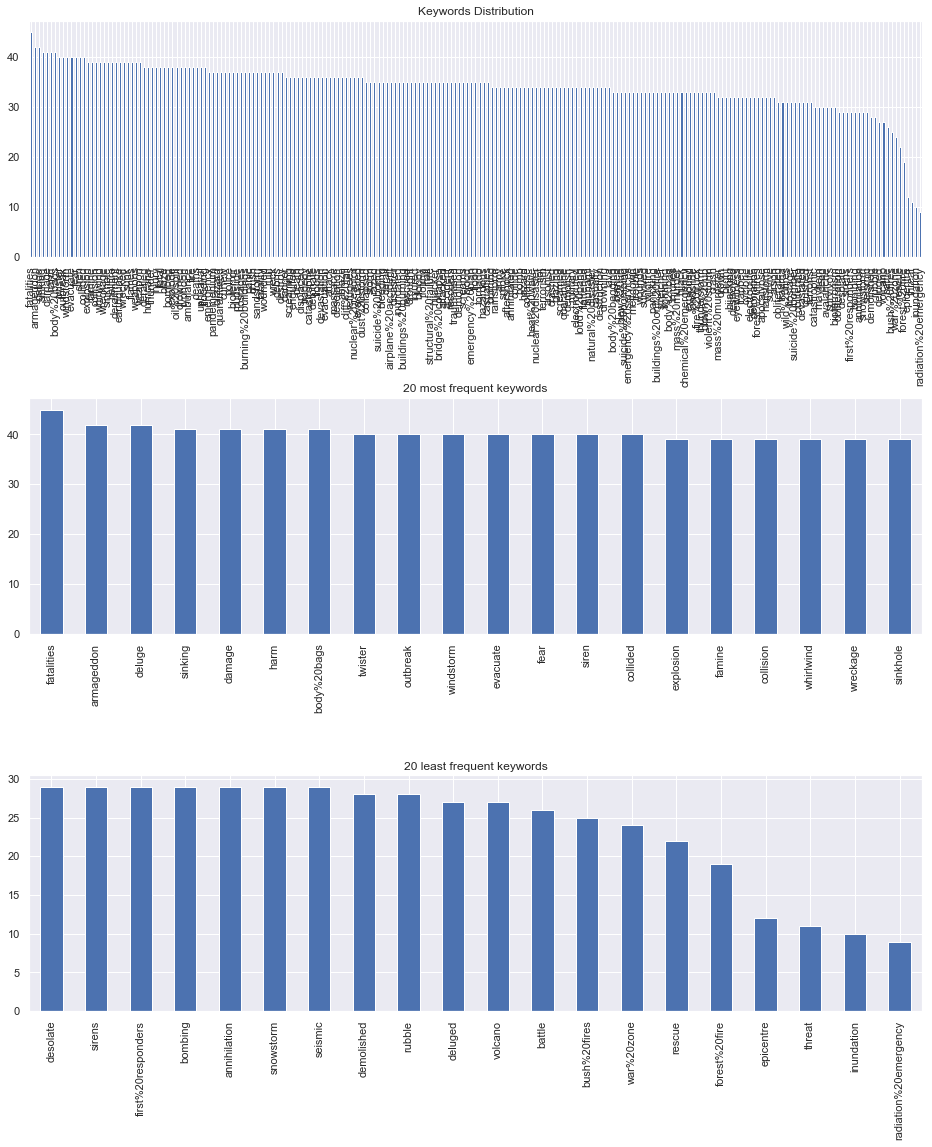

In [535]:
# Distribution of unique values
fig, axs = plt.subplots(3,figsize=(16,10))
train_raw['keyword'].value_counts().plot(kind='bar',ax=axs[0])
axs[0].set_title("Keywords Distribution")
train_raw['keyword'].value_counts().head(20).plot(kind='bar',ax=axs[1])
axs[1].set_title("20 most frequent keywords",)
train_raw['keyword'].value_counts().tail(20).plot(kind='bar',ax=axs[2])
axs[2].set_title("20 least frequent keywords")
plt.subplots_adjust(top=1.5,hspace=0.6)

In [536]:
print(train_raw['keyword'].value_counts().head(1))
print(train_raw['keyword'].value_counts().tail(1))

fatalities    45
Name: keyword, dtype: int64
radiation%20emergency    9
Name: keyword, dtype: int64


In [537]:
# Proportion of keywords between 40 and 30 occurrencies
t = sum((train_raw['keyword'].value_counts()>30) & (train_raw['keyword'].value_counts()<40))/len(train_raw['keyword'].value_counts())
print(f"{t*100:.02f}% of the keywords have between 30 and 40 occurencies")


81.45% of the keywords have between 30 and 40 occurencies


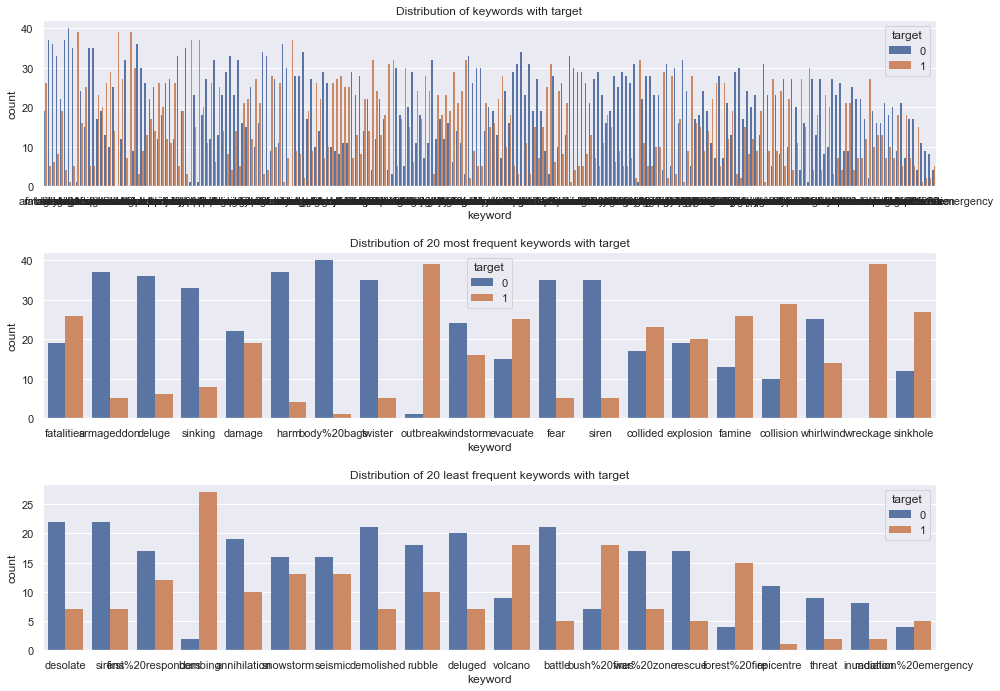

In [538]:
fig, axs = plt.subplots(3,figsize=(16,10))
sns.countplot("keyword",data=train_raw,hue="target",edgecolor=sns.color_palette("dark", 0),order=train_raw['keyword'].value_counts().index,ax=axs[0]).set(title='Distribution of keywords with target')
sns.countplot("keyword",data=train_raw,hue="target",edgecolor=sns.color_palette("dark", 0),order=train_raw['keyword'].value_counts().head(20).index,ax=axs[1]).set(title='Distribution of 20 most frequent keywords with target')
sns.countplot("keyword",data=train_raw,hue="target",edgecolor=sns.color_palette("dark", 0),order=train_raw['keyword'].value_counts().tail(20).index,ax=axs[2]).set(title='Distribution of 20 least frequent keywords with target')
plt.subplots_adjust(top=1,hspace=0.4)

CONCLUSION
- There are very few non null values (**<1%**), hence we could clean this by deleting null values
- There are **221** unique keywords 
- All keywords have a frequency between **45 and 9** occurencies. Most keywords have similar occurencies as **81%** of the keywords have between 30 and 40 occurencies
- Some keywords are highly linked to tweets related to disasters meanwhile others are highly linked to tweets not related to disasters (further details in the following)

## Exploration of location

In [154]:
# Proportion of non null values
print(f"There are {len(train_raw[~train_raw['location'].isna()])/len(train_raw)*100:.02f}% of non null values for location")


There are 66.73% of non null values for location


In [155]:
# Count of unique values
print(f"There are {train_raw[~train_raw['location'].isna()]['location'].nunique()} unique values")

There are 3341 unique values


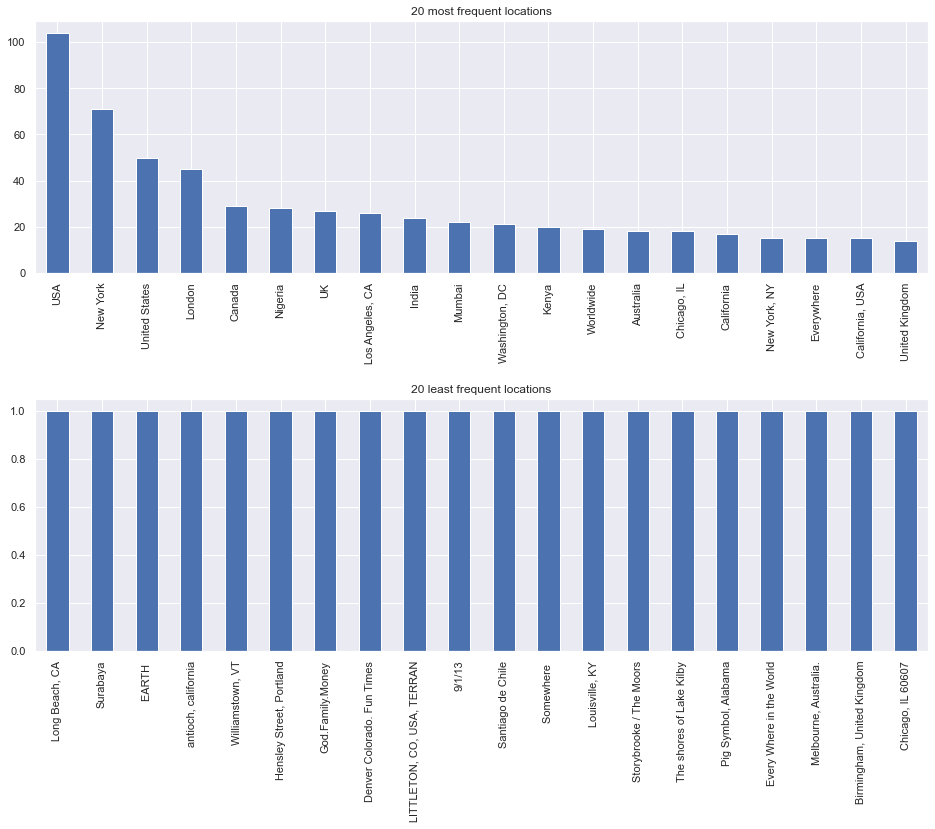

In [163]:
# Distribution of unique values
fig, axs = plt.subplots(2,figsize=(16,10))
train_raw['location'].value_counts().head(20).plot(kind='bar',ax=axs[0])
axs[0].set_title("20 most frequent locations",)
train_raw['location'].value_counts().tail(20).plot(kind='bar',ax=axs[1])
axs[1].set_title("20 least frequent locations")
plt.subplots_adjust(top=1,hspace=0.5)

Equal 1             0.843460
Between 1 and 10    0.146962
Above 10            0.009578
Name: percentage, dtype: float64


<AxesSubplot:>

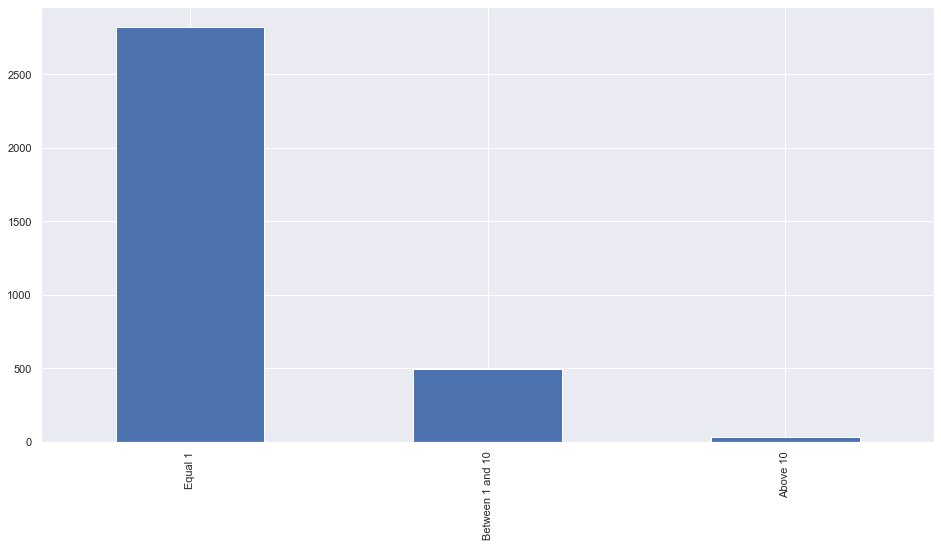

In [214]:
# plot global distribution
occ_loc = {}
occ_loc['Equal 1']=len(train_raw['location'].value_counts()[train_raw['location'].value_counts()==1])
occ_loc['Between 1 and 10']=len(train_raw['location'].value_counts()[(train_raw['location'].value_counts()<=10)&(train_raw['location'].value_counts()>1)])
occ_loc['Above 10']=len(train_raw['location'].value_counts()[train_raw['location'].value_counts()>10])
df_occ_loc = pd.DataFrame(data=occ_loc.values(),index=occ_loc.keys(),columns=['Count'])
df_occ_loc['percentage']=df_occ_loc['Count']/sum(df_occ_loc['Count'])
print(df_occ_loc['percentage'])
df_occ_loc['Count'].plot(kind='bar')

[Text(0.5, 1.0, 'Distribution of most frequent locations with target')]

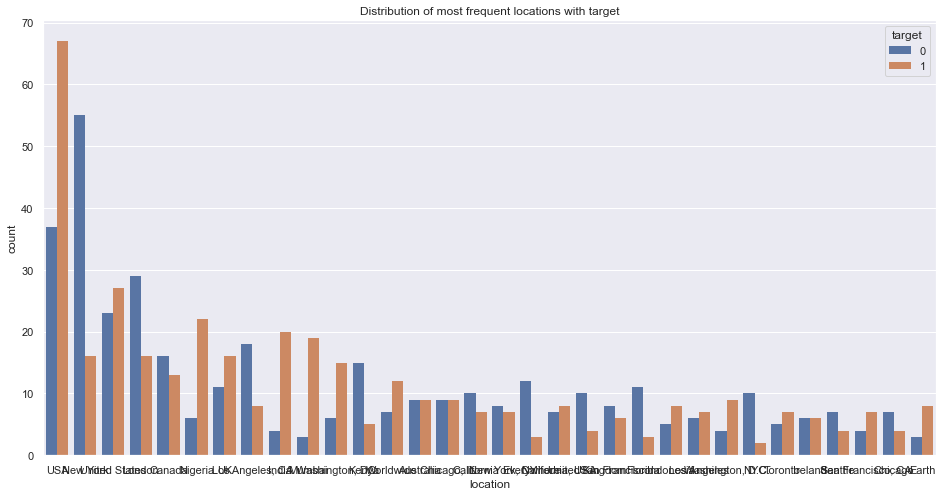

In [215]:
sns.countplot("location",data=train_raw,hue="target",edgecolor=sns.color_palette("dark", 0),order=train_raw['location'].value_counts()[train_raw['location'].value_counts()>10].index).set(title='Distribution of most frequent locations with target')


CONCLUSION
- **33%** of location values are null, hence we will see below how to treat them: 1) avoid this data for the model, 2) fill these missing values
- location occurencies are between **104 and 1**
- most of the locations have only 1 occurency (**84.34%**), probably some cleaning may aggregate some locations together
- for the most frequent locations, some of them are more related to disasters than others. However, this fact is less obvious than keywords

<a id=’exploration_text’></a>
## Exploration of text

In [539]:
#creation of 'text length' feature
train_raw['text length'] = train_raw['text'].map(len)
test_raw['text length'] = test_raw['text'].map(len)

[Text(0.5, 1.0, 'Distribution of text length')]

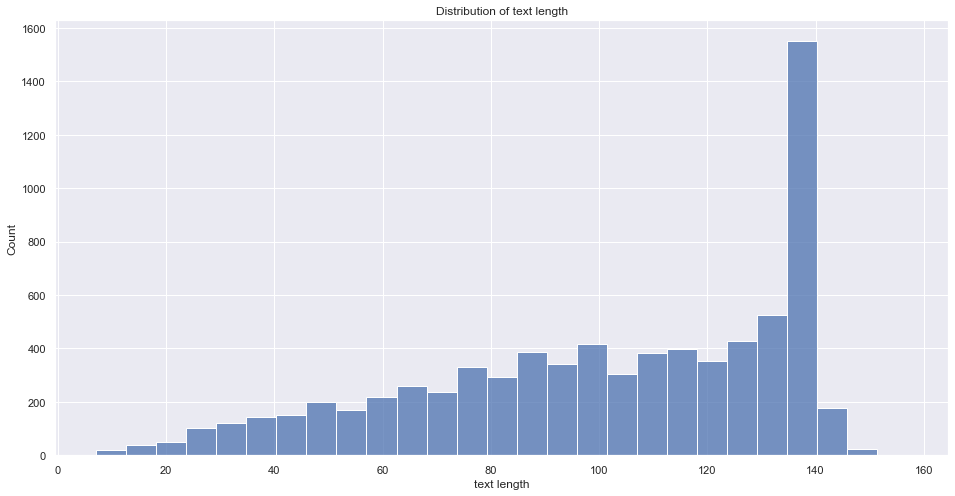

In [230]:
#plot text length distribution
sns.histplot(train_raw['text length']).set(title='Distribution of text length')

In [240]:
# we have tweets with more than 140 characters which normally impossible on twitter. 
#Let's see why we have such texts. 
for i in range(0,5):
    print(train_raw[train_raw['text length']>140]['text'].iloc[i])
    print("\n")

mom: 'we didn't get home as fast as we wished' 
me: 'why is that?'
mom: 'there was an accident and some truck spilt mayonnaise all over ??????


RT nAAYf: First accident in years. Turning onto Chandanee Magu from near MMA. Taxi rammed into me while I was halfway turned. Everyone confÛ_


@willienelson We need help! Horses will die!Please RT &amp; sign petition!Take a stand &amp; be a voice for them! #gilbert23 https://t.co/e8dl1lNCVu


@Barbi_Twins We need help-horses will die! Please RT &amp; sign petition! Take a stand &amp; be a voice for them! #gilbert23 https://t.co/e8dl1lNCVu


@Whippenz We need help! Horses will die!Please RT &amp; sign petition!Take a stand &amp; be a voice for them! #gilbert23 https://t.co/e8dl1lNCVu




In [245]:
# display as raw data from dataframe - example 1
train_raw[train_raw['text length']>140]['text'].iloc[0]

"mom: 'we didn't get home as fast as we wished' \nme: 'why is that?'\nmom: 'there was an accident and some truck spilt mayonnaise all over ??????"

In [247]:
# display as raw data from dataframe - example 2
train_raw[train_raw['text length']>140]['text'].iloc[1]

'RT nAAYf: First accident in years. Turning onto Chandanee Magu from near MMA. Taxi rammed into me while I was halfway turned. Everyone conf\x89Û_'

It seems that there is some specific encode for the text when it is displayed as raw data in dataframe. Some cleaning might be useful

[Text(0.5, 1.0, 'Distribution of text length vs target')]

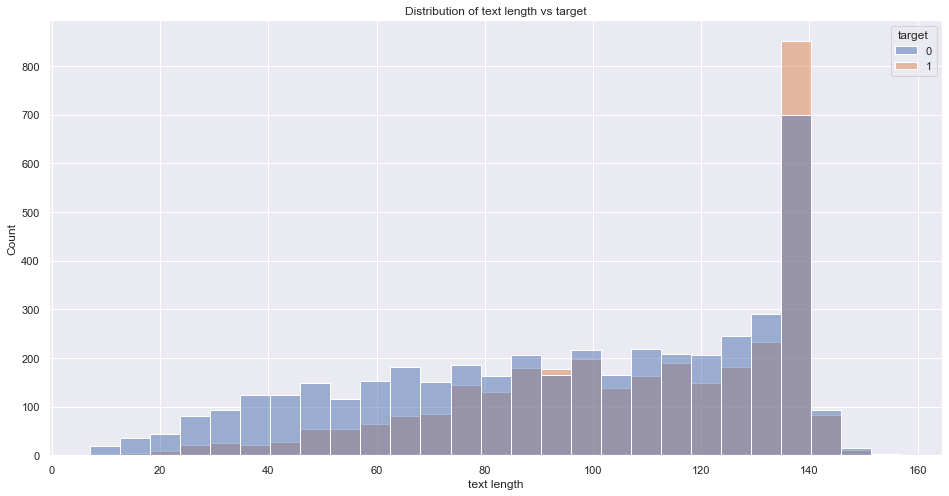

In [246]:
#plot text length distribution vs target
sns.histplot(x='text length',data=train_raw,hue='target').set(title='Distribution of text length vs target')

CONCLUSION
- There is no missing value
- The text length with the most occurencies is 140 (normal as it is the limit)
- In our dataframe, we have texts with length greater than 140 caracters as there is some encoding caracters in the dataframe text
- Regarding the distribution of the length vs the target we can see that 1) when we have very short text, it is unlikely that this is a tweet related to a disaster and 2) when we have a text of length 140 or slightly below, we have a extra chance that the tweet is related to a disaster

## Exploration of target

% of real disaster tweets: 42.97% vs % of no disaster tweets: 57.03%


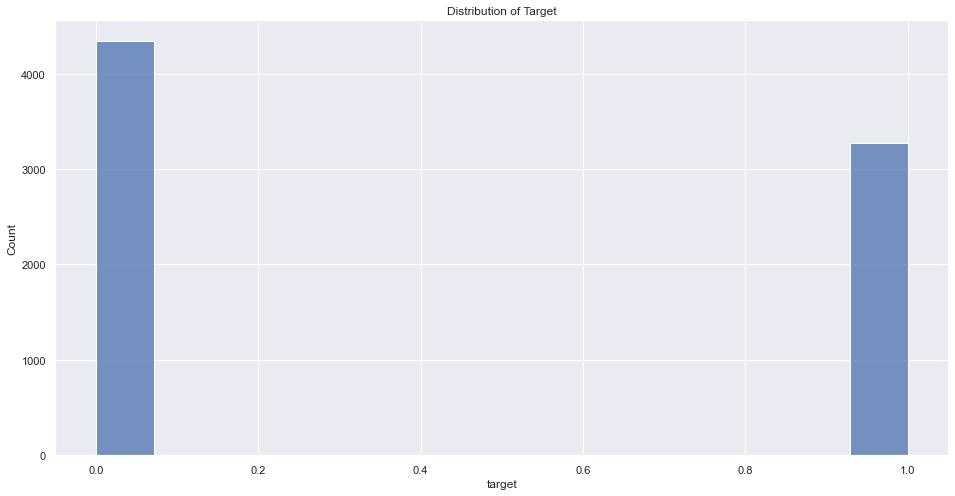

In [306]:
# plot distribution of the target
sns.histplot(train_raw['target']).set(title='Distribution of Target')
print(f"% of real disaster tweets: {len(train_raw[train_raw['target']==1])/len(train_raw)*100:.02f}%" 
      f" vs % of no disaster tweets: {len(train_raw[train_raw['target']==0])/len(train_raw)*100:.02f}%")

CONCLUSION 
- Classes are well balanced
- There is few chance that we need to balance it

# Data Cleaning

## Duplicate

In [299]:
# As shown in global analysis, there is no duplicate in the train set

## Missing Values

As we have only **0.80%** of keywords without values, we can drop these observations

In [1167]:
train = train_raw.copy()
test = test_raw.copy()

In [1168]:
# we confirm that the test set has a low proportion of missing keywords
print(f"There are {len(test_raw[~test_raw['keyword'].isna()])/len(test_raw)*100:.02f}% of non null values for keyword")

There are 99.20% of non null values for keyword


In [1169]:
train = train[train['keyword'].notna()]
test = test[test['keyword'].notna()]

As we have more **33%** of missing values for location and we have **3341** unique values with no true outliers in terms of occurencies, we will avoid using location for our model

## Cleaning keyword

In [605]:
X_train_clean = train.copy()
X_test_clean = test.copy()

In [606]:
# remove punctuation
X_train_clean['keyword_clean'] = X_train_clean['keyword'].astype(str).map(remove_punctuation)

In [607]:
# we can see that due to encoding there are some "20" that correspond whitespace 
X_train_clean['keyword_clean'][X_train_clean['keyword_clean'].str.contains('20')].value_counts()

body20bags              41
oil20spill              38
burning20buildings      37
nuclear20reactor        36
cliff20fall             36
dust20storm             36
buildings20burning      35
structural20failure     35
airplane20accident      35
suicide20bomb           35
emergency20plan         35
bridge20collapse        35
natural20disaster       34
heat20wave              34
loud20bang              34
nuclear20disaster       34
chemical20emergency     33
emergency20services     33
blown20up               33
violent20storm          33
body20bag               33
suicide20bombing        33
mass20murder            33
buildings20on20fire     33
fire20truck             33
body20bagging           33
blew20up                33
mass20murderer          32
forest20fires           32
suicide20bomber         31
wild20fires             31
first20responders       29
bush20fires             25
war20zone               24
forest20fire            19
radiation20emergency     9
Name: keyword_clean, dtype: 

In [608]:
# replace "20"s by whitespaces
X_train_clean['keyword_clean'] = X_train_clean['keyword_clean'].apply(lambda x: x.replace('20',' '))

In [609]:
# lower keywords
X_train_clean['keyword_clean'] = X_train_clean['keyword_clean'].map(lowercase)

In [610]:
# lemmatize keywords
X_train_clean['keyword_clean'] = X_train_clean['keyword_clean'].map(lemma)

In [611]:
# observe the quality of the cleaned keywords
X_train_clean['keyword_clean'].unique()

array(['ablaze', 'accident', 'aftershock', 'airplane accident',
       'ambulance', 'annihilated', 'annihilation', 'apocalypse',
       'armageddon', 'army', 'arson', 'arsonist', 'attack', 'attacked',
       'avalanche', 'battle', 'bioterror', 'bioterrorism', 'blaze',
       'blazing', 'bleeding', 'blew up', 'blight', 'blizzard', 'blood',
       'bloody', 'blown up', 'body bag', 'body bagging', 'bomb', 'bombed',
       'bombing', 'bridge collapse', 'building burning',
       'building on fire', 'burned', 'burning', 'burning building',
       'bush fire', 'casualty', 'catastrophe', 'catastrophic',
       'chemical emergency', 'cliff fall', 'collapse', 'collapsed',
       'collide', 'collided', 'collision', 'crash', 'crashed', 'crush',
       'crushed', 'curfew', 'cyclone', 'damage', 'danger', 'dead',
       'death', 'debris', 'deluge', 'deluged', 'demolish', 'demolished',
       'demolition', 'derail', 'derailed', 'derailment', 'desolate',
       'desolation', 'destroy', 'destroyed', 'd

In [612]:
# we do the same cleaning for the test set
X_test_clean['keyword_clean'] = X_test_clean['keyword'].astype(str).map(remove_punctuation)
X_test_clean['keyword_clean'] = X_test_clean['keyword_clean'].apply(lambda x: x.replace('20',' '))
X_test_clean['keyword_clean'] = X_test_clean['keyword_clean'].map(lowercase)
X_test_clean['keyword_clean'] = X_test_clean['keyword_clean'].map(lemma)

## Cleaning text

In [613]:
# remove punctuation
X_train_clean['text_clean'] = X_train_clean['text'].astype(str).map(remove_punctuation)

In [614]:
# lower text
X_train_clean['text_clean'] = X_train_clean['text_clean'].map(lowercase)

In [615]:
# we can see that there is some text starting by "http" that refers to images
for i in range(20):
    print(X_train_clean['text_clean'].iloc[i])

bbcmtd wholesale markets ablaze httptcolhyxeohy6c
we always try to bring the heavy metal rt httptcoyao1e0xngw
africanbaze breaking newsnigeria flag set ablaze in aba httptco2nndbgwyei
crying out for more set me ablaze
on plus side look at the sky last night it was ablaze httptcoqqsmshaj3n
phdsquares mufc theyve built so much hype around new acquisitions but i doubt they will set the epl ablaze this season
inec office in abia set ablaze  httptco3imaomknna
barbados bridgetown jamaica ûò two cars set ablaze santa cruz ûó head of the st elizabeth police superintende  httptcowdueaj8q4j
ablaze for you lord d
check these out httptcoroi2nsmejj httptco3tj8zjin21 httptcoyduixefipe httptcolxtjc87kls nsfw
on the outside youre ablaze and alive
but youre dead inside
had an awesome time visiting the cfc head office the ancop site and ablaze thanks to tita vida for taking care of us 
soooo pumped for ablaze  southridgelife
i wanted to set chicago ablaze with my preaching but not my hotel httptcoo9qk

So far the image in itself is not interesting for us (maybe for a deeper model), but the fact of having an image may be an information valuable and easy to collect. 
Let's create a new feature telling us if the tweet has an image or not

In [616]:
# create 'has_image' feature
X_train_clean['has_image'] = X_train_clean['text_clean'].str.contains('http')
X_train_clean['has_image'] = X_train_clean['has_image'].replace(True,1).replace(False,0)

In [617]:
# remove image link (can have been done using tfidf min df)
X_train_clean['text_clean'] = X_train_clean['text_clean'].apply(lambda x: remove_word_containing(x,"http"))

In [618]:
# remove stopwords
X_train_clean['text_clean'] = X_train_clean['text_clean'].map(remove_stop_words)

In [619]:
# lemmatize words
X_train_clean['text_clean'] = X_train_clean['text_clean'].map(lemma)

In [620]:
# We do the same cleaning for the test set
X_test_clean['text_clean'] = X_test_clean['text'].astype(str).map(remove_punctuation)
X_test_clean['text_clean'] = X_test_clean['text_clean'].map(lowercase)

X_test_clean['has_image'] = X_test_clean['text_clean'].str.contains('http')
X_test_clean['has_image'] = X_test_clean['has_image'].replace(True,1).replace(False,0)

X_test_clean['text_clean'] = X_test_clean['text_clean'].apply(lambda x: remove_word_containing(x,"http"))
X_test_clean['text_clean'] = X_test_clean['text_clean'].map(remove_stop_words)
X_test_clean['text_clean'] = X_test_clean['text_clean'].map(lemma)

REMARK

Possible cleaning remaining: remove digit?

# Feature Engineering

- bag of words
- tfidf
- word2vec
- scaling?
- vocab qui est dans disaster et pas dans l'autre

- missing values

## Feature Engineering on text

### Bag of Words

In order to limit the number of features with the bag of words and tfidf vectorizer, we will optimze **min_df** and **max_df**

Text(0.5, 1.0, 'Vocabulry size vs min_df')

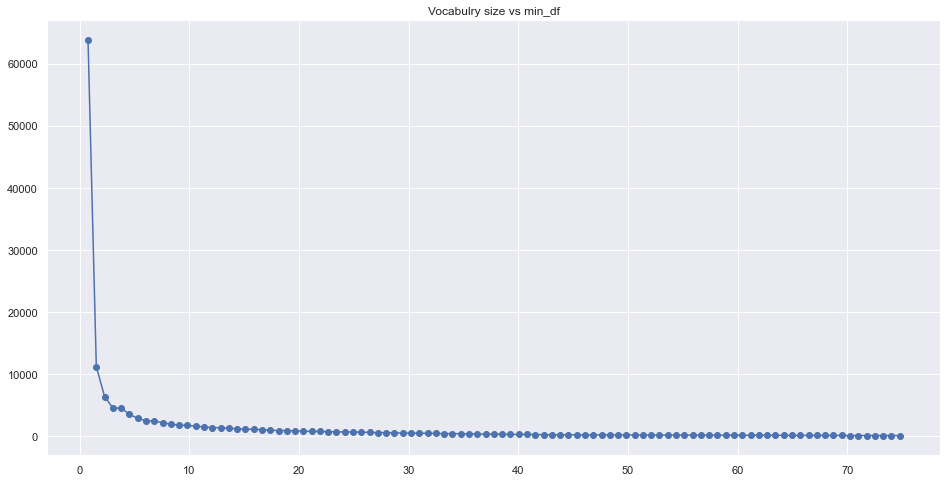

In [835]:
# Plot vocab size vs min_df
vocab_size_mindf = []
for i in np.arange(round(1/len(X_train_clean),4),0.01,0.0001):
    vectorizer = CountVectorizer(min_df=i,max_df=1.0,ngram_range=(1,2))
    vocab_size_mindf.append(vectorizer.fit_transform(X_train_clean['text_clean']).shape[1])

plt.plot(np.arange(round(1/len(X_train_clean),4),0.01,0.0001)*len(X_train_clean),vocab_size_mindf, marker='o')
plt.title('Vocabulry size vs min_df')

We can see there is a strong decrease until min_df=5. Intuitively, we can say that a word or n_gram has no true information to provide if it occures in less than 10 documents. Hence, we will put **min_df = 10**

Text(0.5, 1.0, 'Vocabulry size vs max_df')

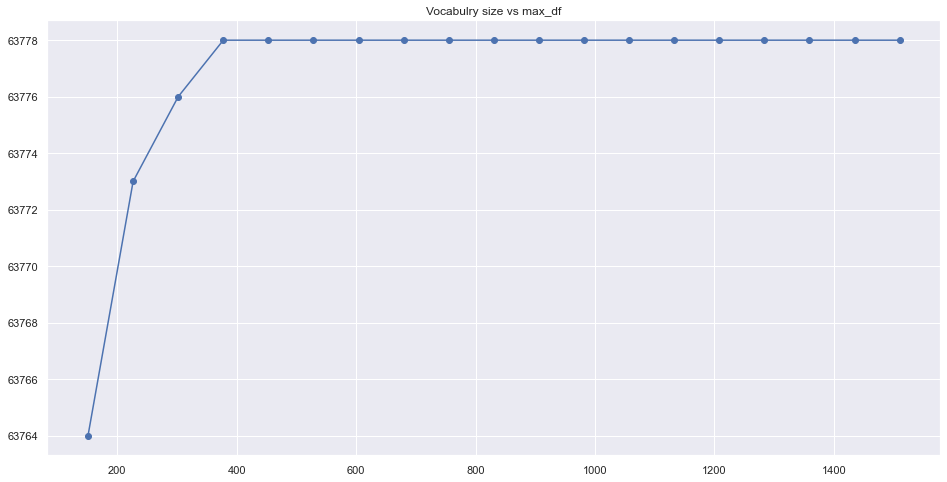

In [846]:
# Plot vocab size vs max_df
vocab_size_maxdf = []
for i in np.arange(0.2,0.01,-0.01):
    vectorizer = CountVectorizer(min_df=10,max_df=i,ngram_range=(1,2))
    vocab_size_maxdf.append(vectorizer.fit_transform(X_train_clean['text_clean']).shape[1])

plt.plot(np.arange(0.2,0.01,-0.01)*len(X_train_clean),vocab_size_maxdf, marker='o')
plt.title('Vocabulry size vs max_df')

We can see the most frequent word appears in less than **400 documents**, hence we will let **max_df = 1.0**

In [892]:
# transformation with Bag of Words
vectorizer = CountVectorizer(min_df=10,max_df=1.0,ngram_range=(1,2))
bog_ngram_train = vectorizer.fit_transform(X_train_clean['text_clean'])
X_names = vectorizer.get_feature_names()
bog_ngram_test = vectorizer.transform(X_test_clean['text_clean'])

In [822]:
print(f"Shape of bog_ngram_train {bog_ngram_train.shape}")
print(f"Shape of bog_ngram_test {bog_ngram_test.shape}")

Shape of bog_ngram_train (7552, 1729)
Shape of bog_ngram_test (3237, 1729)


In this section, we have done a Bag of Words vectorization. At this point, we have a large number of features (**63778 words**). So far, we will not work on the optimization of the parameters, we will do so in Feature Selection section with a dimensionality reduction.

REMARK

Even if min_df = 10 is based on observations, we could have chosen min_df = 5. This is one parameter on which we can work on to improve our performance.

### Tfidf

As the frequency of words is the same wether it is bag of words or tfidf vectorizer, we will use the same parameters for min_df and max_df

In [847]:
# transformation with tfidf
vectorizer = TfidfVectorizer(min_df=10,max_df=1.0,ngram_range=(1,2))
tfidf_ngram_train = vectorizer.fit_transform(X_train_clean['text_clean'])
tfidf_ngram_test = vectorizer.transform(X_test_clean['text_clean'])

In [848]:
print(f"Shape of tfidf_ngram_train {tfidf_ngram_train.shape}")
print(f"Shape of tfidf_ngram_test {tfidf_ngram_test.shape}")

Shape of tfidf_ngram_train (7552, 1729)
Shape of tfidf_ngram_test (3237, 1729)


In this section, we have done a Tfidf vectorization. At this point, we have a large number of features (**63778 words**). Similarly, we will not work on the optimization of the parameters, we will do so in Feature Selection section with a dimensionality reduction.

### Word2Vec

In [564]:
# Dowload pre-trained word2vec "glove-twitter-200" model
word2vec = api.load("glove-twitter-200")

[==================================================] 100.0% 758.5/758.5MB downloaded


In [633]:
# Embed text_clean into array of 
# shape(# documents, # words in document, # length of vector representation)
# i.e. shape(7552, # words in  document, 200) for train set
# i.e. shape(3237, # words in document, 200) for test set
X_train_clean_embed = embedding(word2vec, X_train_clean['text_clean'].map(nltk.word_tokenize))
X_test_clean_embed = embedding(word2vec, X_test_clean['text_clean'].map(nltk.word_tokenize))

[Text(0.5, 1.0, 'Distribution of # words in document')]

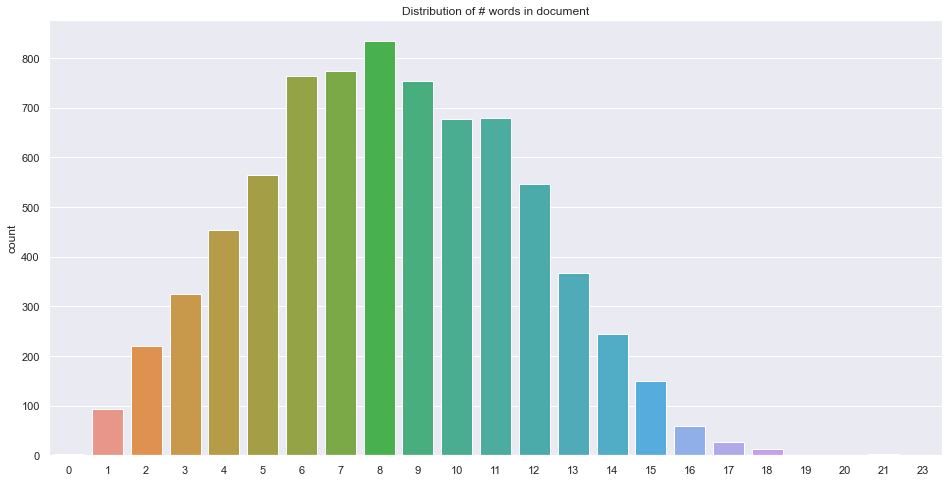

In [649]:
# Plot the distribution of # words in document
len_words_train = [x.shape[0] for x in X_train_clean_embed]
sns.countplot(len_words_train).set(title='Distribution of # words in document')

We can pad with a length of 18 words without missing much information

In [653]:
# Pad the training and test embedded sentences
X_train_clean_pad = pad_sequences(X_train_clean_embed, dtype='float32', padding='post', maxlen=18)
X_test_clean_pad = pad_sequences(X_test_clean_embed, dtype='float32', padding='post', maxlen=18)

print(f"X_train_clean_pad shape: {X_train_clean_pad.shape}")
print(f"X_test_clean_pad shape: {X_test_clean_pad.shape}")

X_train_clean_pad shape: (7552, 18, 200)
X_test_clean_pad shape: (3237, 18, 200)


## Feature Engineering on keywords

In [713]:
# One-hot encode keyword feature
enc = OneHotEncoder(handle_unknown='ignore')
keywords_sparse_train = enc.fit_transform(X_train_clean['keyword_clean'].values.reshape(-1,1))
keywords_sparse_test = enc.transform(X_test_clean['keyword_clean'].values.reshape(-1,1))
keywords_features_name = enc.get_feature_names(['kw'])

In [714]:
print(f"Shape of tfidf_ngram_train {keywords_sparse_train.shape}")
print(f"Shape of tfidf_ngram_test {keywords_sparse_test.shape}")

Shape of tfidf_ngram_train (7552, 211)
Shape of tfidf_ngram_test (3237, 211)


In [1304]:
# Kepp categories list of the one hot encoding
df_cat = pd.DataFrame({'ind':[i for i in range(len(one_hot_cat))],'keyword':keywords_features_name})

## Feature Engineering on text length

As seen previously, text length feature has a maximum value around **140** meanwhile the other features are close to 0.

We need to scale this feature to handle it properly 

In [697]:
# Scale text length feature
new_scaler = MinMaxScaler()
X_train_clean['scaled text length'] = new_scaler.fit_transform(X_train_clean['text length'].values.reshape(-1,1))
X_test_clean['scaled text length'] = new_scaler.transform(X_test_clean['text length'].values.reshape(-1,1))

## Split inputs/target

In [699]:
# Split target/feature for train and test set

# Join X_test_clean with target_test as some missing data have been deleted
full_test_set = pd.merge(X_test_clean,target_test,how="inner",left_on='id',right_on='id')

#Split train
y_train = X_train_clean[['id','target']]
X_train = X_train_clean.drop('target',axis=1)

#Split test
y_test = full_test_set[['id','target']]
X_test = full_test_set.drop('target',axis=1)

# Feature Selection

## Dependency keyword vs target

As we have one-hot encoded the keyword feature, we can use chi-2 test and Cramer's V to determine wether there is depedency between a specific keyword and target.

As we have numerous keywords, we will able to select only keywords that have significant dependency with target

In [753]:
# Create DataFrame where we stock chi2, p-value and Cramer's V
df_cramer = pd.DataFrame(columns=['chi2','p-value','cramer'])

# Compute chi2 test and Cramer's V for each keayword and append it to df_cramer
for i in range(keywords_sparse_train.toarray().shape[1]):
    tabKeyTarget = pd.crosstab(keywords_sparse_train.toarray()[:,i], y_train['target'])
    chi2, p, dof, con_table = stats.chi2_contingency(tabKeyTarget)
    cramer = cramer_v(chi2, dof, sum(keywords_sparse_train.toarray()[:,i]))
    df_cramer = df_cramer.append({"chi2":chi2,"p-value":p,"cramer":cramer}, ignore_index = True)


In [754]:
# Merge cramer and chi2 information with the corresponding keywords
df_cramer_cat = pd.merge(df_cramer, df_cat, left_index=True, right_on='ind')

In [775]:
# Display most dependent keywords with target
df_cramer_cat.sort_values(by="cramer",ascending=False).head()

,chi2,p-value,cramer,ind,keyword
209,50.159800,1.417216e-12,1.134085,209,wreckage
67,50.159800,1.417216e-12,1.134085,67,derailment
59,47.457081,5.622150e-12,1.132530,59,debris
145,47.014611,7.045949e-12,1.084143,145,outbreak
144,44.323103,2.784110e-11,1.079999,144,oil spill


As shown below, as we have a degree of liberty equal to 1, we have a strong effect of the feature when Cramer's V above or equal to 0.5.
Let's keep only the features having a Cramer's V above or equal to 0.5
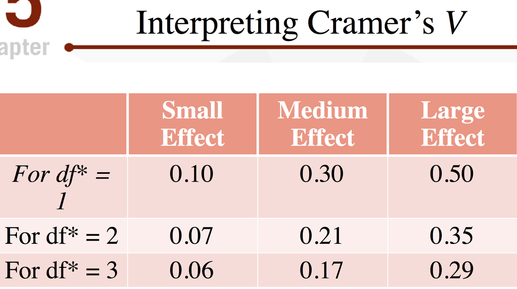

In [881]:
# Take the one-hot encoded sparse matrix with only significant dependency
reduced_keywords_sparse_train = keywords_sparse_train[:,df_cramer_cat[df_cramer_cat['cramer']>=0.5]['ind'].values]
reduced_keywords_sparse_test = keywords_sparse_test[:,df_cramer_cat[df_cramer_cat['cramer']>=0.5]['ind'].values]
reduced_keyword_label = df_cat[df_cramer_cat['cramer']>=0.5]['keyword'].values

In [945]:
reduced_keywords_sparse_train

<7552x91 sparse matrix of type '<class 'numpy.float64'>'
	with 3228 stored elements in Compressed Sparse Row format>

## Correlation text length vs target

As we have seen in the histogram with target in [Exploration of text](#exploration_text) section. We can see that there might be a dependency between text length and target. 

We need to compute it statiscally to confirm or not our intuition

In [777]:
# Compute correlation
X_train_clean[['scaled text length','target']].corr()

,scaled text length,target
scaled text length,1.000000,0.180539
target,0.180539,1.000000


We can see that statistically, the text length is not really dependent to target. 

REMARK

For further engineering on text length, we might try to create a non linear feature classifying whether the text is shorter than 30 characters, between 30 and 130 and above 130 characters.

## Dependency has_image vs target

In [948]:
# Compute Chi2 test and Cramer's V
tabImageTarget = pd.crosstab(X_train_clean['has_image'], y_train['target'])
chi2, p, dof, con_table = stats.chi2_contingency(tabImageTarget)
cramer = cramer_v(chi2, dof, len(y_train['target']))
print(f"p-value equals {p} hence has_image and target are dependent")
print(f"chi-2 equals {chi2}")
print(f"Cramer's V equals {cramer} hence there is a medium dependency between has_image and target")

p-value equals 3.4493491517829487e-103 hence has_image and target are dependent
chi-2 equals 465.25770802975416
Cramer's V equals 0.2482080129540903 hence there is a medium dependency between has_image and target


## Dimensionality reduction with dependency for text vectorizer

So far, we have with the bag of words or the tfidf a matrices with high dimension (**1729**). In order, to reduce these matrices dimension, we will compute chi-2 and Cramer's V  for each feature and keep only the most significant ones

### Bag of words

In [1355]:
%%time
# Create DataFrame where we stock chi2, p-value and Cramer's V
df_cramer = pd.DataFrame(columns=['chi2','p-value','cramer'])

# Compute chi2 test and Cramer's V for each n-gram and append it to df_cramer
for i in range(bog_ngram_train.toarray().shape[1]):
    tabBogTarget = pd.crosstab(bog_ngram_train.toarray()[:,i], y_train['target'])
    chi2, p, dof, con_table = stats.chi2_contingency(tabBogTarget)
    cramer = cramer_v(chi2, dof, len(y_train['target']))
    df_cramer = df_cramer.append({"chi2":chi2,"p-value":p,"cramer":cramer}, ignore_index = True)

CPU times: user 35.3 s, sys: 12.3 s, total: 47.6 s
Wall time: 48.2 s


In [1356]:
# See statistical values for the different features
print(df_cramer.sort_values(by="cramer",ascending=False))
print(f"There are {len(df_cramer[df_cramer['p-value']<=0.05])} features having a statistically significant dependency with the target")

            chi2  ...    cramer
1040   81.351429  ...  0.103789
266   126.447913  ...  0.091498
1445  115.460005  ...  0.087432
732   111.781729  ...  0.086028
824   110.901216  ...  0.085688
...          ...  ...       ...
1473    0.000000  ...  0.000000
270     0.000000  ...  0.000000
294     0.000000  ...  0.000000
1450    0.000000  ...  0.000000
1127    0.000000  ...  0.000000

[1729 rows x 3 columns]
There are 868 features having a statistically significant dependency with the target


We can see that the all the cramer's V are equal or below 0.1 which means that the dependency of each feature is quite low with the target. However, there are numerous features (**868**) that has a p value below 0.05. We will take these features for our models.

In [976]:
"""
OLD
# Take the bag of words sparse matrix with only significant dependency
reduced_bog_ngram_train = bog_ngram_train[:,df_cramer[df_cramer['p-value']<=0.05].index]
reduced_bog_ngram_test = bog_ngram_test[:,df_cramer[df_cramer['p-value']<=0.05].index]
"""

In [1357]:
reduced_bog_vocab = np.array(X_names)[df_cramer[df_cramer['p-value']<=0.05].index.values]

In [1358]:
# transformation with Bag of Words
vectorizer_bog = CountVectorizer(vocabulary=reduced_bog_vocab)
reduced_bog_ngram_train = vectorizer_bog.fit_transform(X_train_clean['text_clean'])
reduced_bog_ngram_test = vectorizer_bog.transform(X_test_clean['text_clean'])

In [1359]:
reduced_bog_ngram_train.shape

(7552, 868)

### Tfidf

In [1360]:
%%time
# Create DataFrame where we stock chi2, p-value and Cramer's V
df_cramer = pd.DataFrame(columns=['chi2','p-value','cramer'])

# Compute chi2 test and Cramer's V for each n-gram and append it to df_cramer
for i in range(tfidf_ngram_train.toarray().shape[1]):
    tabTfidfTarget = pd.crosstab(tfidf_ngram_train.toarray()[:,i], y_train['target'])
    chi2, p, dof, con_table = stats.chi2_contingency(tabTfidfTarget)
    cramer = cramer_v(chi2, dof, len(y_train['target']))
    df_cramer = df_cramer.append({"chi2":chi2,"p-value":p,"cramer":cramer}, ignore_index = True)

CPU times: user 35.4 s, sys: 11.6 s, total: 47 s
Wall time: 47.4 s


In [1361]:
# See statistical values for the different features
print(df_cramer.sort_values(by="cramer",ascending=False))
print(f"There are {len(df_cramer[df_cramer['p-value']<=0.05])} features having a statistically significant dependency with the target")

           chi2  ...    cramer
1462  29.930182  ...  0.062954
646   29.930182  ...  0.062954
1634  29.930182  ...  0.062954
1296  29.930182  ...  0.062954
76    29.930182  ...  0.062954
...         ...  ...       ...
119    4.655227  ...  0.009384
748    5.160722  ...  0.009242
1724   3.737164  ...  0.009082
1709   2.989341  ...  0.008898
538    0.246162  ...  0.005709

[1729 rows x 3 columns]
There are 356 features having a statistically significant dependency with the target


Similarly as bag of words, we can see that the all the cramer's V are equal or below 0.1 which means that the dependency of each feature is quite low with the target. However, there are numerous features (**356**) that has a p value below 0.05. We will take these features for our models.

In [993]:
""" OLD
# Take the bag of words sparse matrix with only significant dependency
reduced_tfidf_ngram_train = tfidf_ngram_train[:,df_cramer[df_cramer['p-value']<=0.05].index]
reduced_tfidf_ngram_test = tfidf_ngram_test[:,df_cramer[df_cramer['p-value']<=0.05].index]
"""

In [1362]:
# Only take the vocabulary with words being dependent with target
reduced_tfidf_vocab = np.array(X_names)[df_cramer[df_cramer['p-value']<=0.05].index.values]

In [1363]:
# Re-do the tfidf with only the reduced vocabulary
vectorizer_tfidf = CountVectorizer(vocabulary=reduced_tfidf_vocab)
reduced_tfidf_ngram_train = vectorizer_tfidf.fit_transform(X_train_clean['text_clean'])
reduced_tfidf_ngram_test = vectorizer_tfidf.transform(X_test_clean['text_clean'])

## Creation of input

In [1364]:
# Concatenate the features altogether
X_train_bog_final = hstack((reduced_keywords_sparse_train,
                       X_train_clean['has_image'].values.reshape(len(X_train_clean['has_image']),1),
                      reduced_bog_ngram_train))
X_test_bog_final = hstack((reduced_keywords_sparse_test,
                       X_test_clean['has_image'].values.reshape(len(X_test_clean['has_image']),1),
                      reduced_bog_ngram_test))

In [1365]:
# Concatenate features' label altogether
label_bog_final = pd.concat([pd.Series(reduced_keyword_label),
                     pd.Series(np.array('has_image')),
                     pd.Series(reduced_bog_vocab)], axis=0).values

In [988]:
"""OLD
X_train_bog_final_2 = hstack((reduced_keywords_sparse_train,
                       X_train_clean['has_image'].values.reshape(len(X_train_clean['has_image']),1),
                      reduced_bog_ngram_train_2))
X_test_bog_final_2 = hstack((reduced_keywords_sparse_test,
                       X_test_clean['has_image'].values.reshape(len(X_test_clean['has_image']),1),
                      reduced_bog_ngram_test_2))
                      """

In [1366]:
X_train_tfidf_final = hstack((reduced_keywords_sparse_train,
                       X_train_clean['has_image'].values.reshape(len(X_train_clean['has_image']),1),
                      reduced_tfidf_ngram_train))
X_test_tfidf_final = hstack((reduced_keywords_sparse_test,
                       X_test_clean['has_image'].values.reshape(len(X_test_clean['has_image']),1),
                      reduced_tfidf_ngram_test))

In [1367]:
# Concatenate features' label altogether
label_tfidf_final = pd.concat([pd.Series(reduced_keyword_label),
                     pd.Series(np.array('has_image')),
                     pd.Series(reduced_tfidf_vocab)], axis=0).values

In [999]:
"""OLD
X_train_tfidf_final_2 = hstack((reduced_keywords_sparse_train,
                       X_train_clean['has_image'].values.reshape(len(X_train_clean['has_image']),1),
                      reduced_tfidf_ngram_train_2))
X_test_tfidf_final_2 = hstack((reduced_keywords_sparse_test,
                       X_test_clean['has_image'].values.reshape(len(X_test_clean['has_image']),1),
                      reduced_tfidf_ngram_test_2))"""

# Models

## Naive Bayes

### first scores

In [1007]:
multi_nb = MultinomialNB()
multi_nb.fit(X_train_bog_final, y_train['target'])
print(f"Score on train: {multi_nb.score(X_train_bog_final,y_train['target'])}")
print(f"Score on test: {multi_nb.score(X_test_bog_final,y_test['target'])}")

Score on train: 0.8135593220338984
Score on test: 0.637936360827927


In [1008]:
"""OLD
multi_nb = MultinomialNB()
multi_nb.fit(X_train_bog_final_2, y_train['target'])
print(f"Score on train: {multi_nb.score(X_train_bog_final_2,y_train['target'])}")
print(f"Score on test: {multi_nb.score(X_test_bog_final_2,y_test['target'])}")
"""

Score on train: 0.8164724576271186
Score on test: 0.6113685511275873


In [1009]:
multi_nb = MultinomialNB()
multi_nb.fit(X_train_tfidf_final, y_train['target'])
print(f"Score on train: {multi_nb.score(X_train_tfidf_final,y_train['target'])}")
print(f"Score on test: {multi_nb.score(X_test_tfidf_final,y_test['target'])}")

Score on train: 0.753177966101695
Score on test: 0.7417361754711153


In [1131]:
"""
OLD
multi_nb = MultinomialNB()
multi_nb.fit(X_train_tfidf_final_2, y_train['target'])
print(f"Score on train: {multi_nb.score(X_train_tfidf_final_2,y_train['target'])}")
print(f"Score on test: {multi_nb.score(X_test_tfidf_final_2,y_test['target'])}")
"""

Score on train: 0.7436440677966102
Score on test: 0.735248687055916


### cross_validation

In [1038]:
""" OLD
cv_nb = cross_validate( MultinomialNB(), X_train_bog_final, y_train['target'], scoring = "accuracy")
print(cv_nb['test_score'])
print(cv_nb['test_score'].mean())
cv_nb = cross_validate( MultinomialNB(), X_train_bog_final_2, y_train['target'], scoring = "accuracy")
print(cv_nb['test_score'])
print(cv_nb['test_score'].mean())
cv_nb = cross_validate( MultinomialNB(), X_train_tfidf_final, y_train['target'], scoring = "accuracy")
print(cv_nb['test_score'])
print(cv_nb['test_score'].mean())
cv_nb = cross_validate( MultinomialNB(), X_train_tfidf_final_2, y_train['target'], scoring = "accuracy")
print(cv_nb['test_score'])
print(cv_nb['test_score'].mean())
"""

[0.72799471 0.70880212 0.71655629 0.72913907 0.76754967]
0.7300083712816827
[0.73924553 0.70880212 0.73576159 0.72649007 0.76423841]
0.7349075433575415
[0.64195897 0.61416281 0.57350993 0.60794702 0.65099338]
0.6177144209571311
[0.65122435 0.64923891 0.59536424 0.66225166 0.69403974]
0.6504237796994229


### GridSearch

In [1033]:
params = {'alpha': (0.01,0.1,1,10,25,50,75,100)}

In [1370]:
grid_search = GridSearchCV(estimator=MultinomialNB(), 
             param_grid=params, 
             refit=True, 
             verbose=0, 
             cv=10, 
             n_jobs=-1,
             scoring = "accuracy")

grid_search.fit(X_train_bog_final, y_train['target'])
print(grid_search.best_params_)
print(grid_search.score(X_train_bog_final, y_train['target']))
print(grid_search.score(X_test_bog_final, y_test['target']))

{'alpha': 50}
0.806541313559322
0.651220265678097


In [1035]:
"""
OLD
grid_search = GridSearchCV(estimator=MultinomialNB(), 
             param_grid=params, 
             refit=True, 
             verbose=0, 
             cv=10, 
             n_jobs=-1,
             scoring = "accuracy")

grid_search.fit(X_train_bog_final_2, y_train['target'])
print(grid_search.best_params_)
print(grid_search.score(X_train_bog_final_2, y_train['target']))
print(grid_search.score(X_test_bog_final_2, y_test['target']))
"""

{'alpha': 50}
0.806541313559322
0.651220265678097


In [1371]:
grid_search = GridSearchCV(estimator=MultinomialNB(), 
             param_grid=params, 
             refit=True, 
             verbose=0, 
             cv=10, 
             n_jobs=-1,
             scoring = "accuracy")

grid_search.fit(X_train_tfidf_final, y_train['target'])
print(grid_search.best_params_)
print(grid_search.score(X_train_tfidf_final, y_train['target']))
print(grid_search.score(X_test_tfidf_final, y_test['target']))

{'alpha': 75}
0.7388771186440678
0.7377201112140871


In [1037]:
"""
OLD
grid_search = GridSearchCV(estimator=MultinomialNB(), 
             param_grid=params, 
             refit=True, 
             verbose=0, 
             cv=10, 
             n_jobs=-1,
             scoring = "accuracy")

grid_search.fit(X_train_tfidf_final_2, y_train['target'])
print(grid_search.best_params_)
print(grid_search.score(X_train_tfidf_final_2, y_train['target']))
print(grid_search.score(X_test_tfidf_final_2, y_test['target']))
"""

{'alpha': 75}
0.7388771186440678
0.7377201112140871


## Random Forest

In [1382]:
param_grid_rfc = {"max_depth": [5,10],
                  "max_features": [10, 25, 50],
                  "min_samples_split": [25, 50, 100],
                  "min_samples_leaf": [25, 50, 100],
                  "n_estimators" :[100, 200]

In [1383]:
grid_rfc_bog = GridSearchCV(RandomForestClassifier(), 
                        param_grid_rfc, 
                        refit=True, 
                        verbose=0, 
                        cv=10, 
                        n_jobs=-1,
                        scoring = "accuracy")
grid_rfc_bog.fit(X_train_bog_final, y_train['target'])
print(grid_rfc_bog.best_params_)
print(grid_rfc_bog.score(X_train_bog_final, y_train['target']))
print(grid_rfc_bog.score(X_test_bog_final, y_test['target']))

{'max_depth': 10, 'max_features': 50, 'min_samples_leaf': 25, 'min_samples_split': 50, 'n_estimators': 100}
0.6979608050847458
0.8551127587272166


In [1406]:
# Create DataFrame with the feature importance and the corresponding feature
features_labels_bog = pd.concat([pd.DataFrame(grid_rfc_bog.best_estimator_.feature_importances_),pd.DataFrame(
label_bog_final)],axis=1)
features_labels_bog.columns = ['feature_importance','feature_name']

In [1407]:
# Visualize the most important features
features_labels_bog.sort_values(by='feature_importance', ascending=False)

,feature_importance,feature_name
91,0.214662,has_image
390,0.059980,fire
867,0.042803,train
510,0.040714,killed
233,0.037336,california
...,...,...
354,0.000000,evacuated
358,0.000000,every
360,0.000000,everything
361,0.000000,exchanging


In [1443]:
features_labels_bog['feature_name'] = features_labels_bog['feature_name'].astype(str)

In [1453]:
# Count how many features have a feature importance = 0
features_labels_bog[features_labels_bog['feature_importance']>0]

,feature_importance,feature_name
1,0.000865,kw_airplane accident
8,0.000427,kw_blazing
10,0.000085,kw_blew up
16,0.006128,kw_body bag
20,0.000028,kw_building on fire
...,...,...
939,0.000088,would
942,0.009680,wreckage
947,0.001365,year
951,0.000377,youre


There are only **174 features** having a feature importance higher that 0

[Text(0, 0, 'has_image'),
 Text(1, 0, 'fire'),
 Text(2, 0, 'train'),
 Text(3, 0, 'killed'),
 Text(4, 0, 'california'),
 Text(5, 0, 'hiroshima'),
 Text(6, 0, 'suicide'),
 Text(7, 0, 'bombing'),
 Text(8, 0, 'wildfire'),
 Text(9, 0, 'northern'),
 Text(10, 0, 'mh370'),
 Text(11, 0, 'debris'),
 Text(12, 0, 'im'),
 Text(13, 0, 'police'),
 Text(14, 0, 'pm'),
 Text(15, 0, 'bomb'),
 Text(16, 0, 'bomber'),
 Text(17, 0, 'atomic'),
 Text(18, 0, 'storm'),
 Text(19, 0, 'building'),
 Text(20, 0, 'news'),
 Text(21, 0, 'wreckage'),
 Text(22, 0, 'migrant'),
 Text(23, 0, 'accident'),
 Text(24, 0, 'disaster'),
 Text(25, 0, 'spill'),
 Text(26, 0, 'fatal'),
 Text(27, 0, 'warning'),
 Text(28, 0, 'japan'),
 Text(29, 0, 'severe'),
 Text(30, 0, 'full'),
 Text(31, 0, 'crash'),
 Text(32, 0, 'confirmed'),
 Text(33, 0, 'malaysia'),
 Text(34, 0, 'love'),
 Text(35, 0, 'kw_body bag'),
 Text(36, 0, 'home'),
 Text(37, 0, 'bag'),
 Text(38, 0, 'kw_wreckage'),
 Text(39, 0, 'outbreak'),
 Text(40, 0, 'near'),
 Text(41, 0, 'y

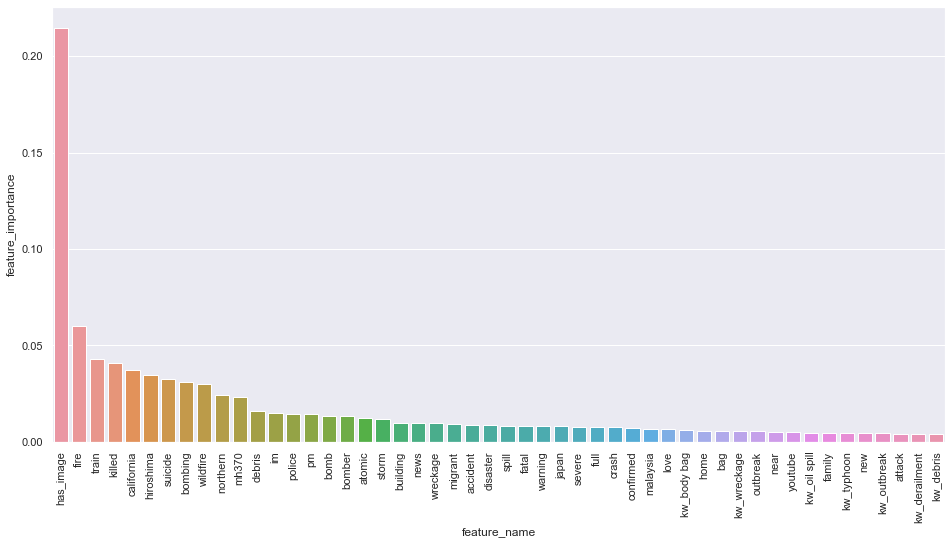

In [1457]:
ax = sns.barplot(x="feature_name",
                 y="feature_importance", 
                 data=features_labels_bog[features_labels_bog['feature_importance']>0].sort_values(by='feature_importance', 
                                                                                                   ascending=False)[0:50])
ax.set_xticklabels(ax.get_xticklabels(),rotation=90)


We can see that **has_image** has a strong importance in this model compared to the other ones, maybe the model relues too much on that feature. Also we can see that there is very few keywords in this top. Let's see what is the importance of the keywords.

In [1454]:
# Count how many features have a feature importance = 0
features_labels_bog[(features_labels_bog['feature_importance']>0) 
                    & 
                    (features_labels_bog['feature_name'].str.contains('kw'))].sort_values(by='feature_importance',
                                                                                         ascending=False)


,feature_importance,feature_name
16,0.006128,kw_body bag
89,0.005729,kw_wreckage
56,0.004757,kw_oil spill
83,0.004529,kw_typhoon
57,0.004370,kw_outbreak
30,0.004228,kw_derailment
27,0.003945,kw_debris
72,0.002612,kw_suicide bomb
43,0.002446,kw_forest fire
64,0.000968,kw_sandstorm


In [1054]:
"""
OLD
grid_rfc = GridSearchCV(RandomForestClassifier(), 
                        param_grid_rfc, 
                        refit=True, 
                        verbose=0, 
                        cv=10, 
                        n_jobs=-1,
                        scoring = "accuracy")
grid_rfc.fit(X_train_bog_final_2, y_train['target'])
print(grid_rfc.best_params_)
print(grid_rfc.score(X_train_bog_final_2, y_train['target']))
print(grid_rfc.score(X_test_bog_final_2, y_test['target']))
"""

{'max_depth': 10, 'max_features': 2, 'min_samples_leaf': 3, 'min_samples_split': 2, 'n_estimators': 100}
0.5952065677966102
0.982700030892802


In [1375]:
grid_rfc_tfidf = GridSearchCV(RandomForestClassifier(), 
                        param_grid_rfc, 
                        refit=True, 
                        verbose=0, 
                        cv=10, 
                        n_jobs=-1,
                        scoring = "accuracy")
grid_rfc_tfidf.fit(X_train_tfidf_final, y_train['target'])
print(grid_rfc_tfidf.best_params_)
print(grid_rfc_tfidf.score(X_train_tfidf_final, y_train['target']))
print(grid_rfc_tfidf.score(X_test_tfidf_final, y_test['target']))

{'max_depth': 10, 'max_features': 50, 'min_samples_leaf': 25, 'min_samples_split': 50, 'n_estimators': 100}
0.7023305084745762
0.8254556688291628


In [1380]:
features_labels_bog = pd.concat([pd.DataFrame(grid_rfc.best_estimator_.feature_importances_),pd.DataFrame(
label_bog_final)],axis=1)

In [1396]:
features_labels_bog = pd.concat([pd.DataFrame(grid_rfc.best_estimator_.feature_importances_),pd.DataFrame(
label_bog_final)],axis=1)
features_labels_bog.columns = ['feature importance','feature name']

In [1399]:
features_labels_bog.columns = ['feature importance','feature name']

In [19]:
b = [1,2]
a=[1,2]

In [20]:
b.extend([1,2])

In [23]:
if 5%2:
    print('ok')

ok


In [25]:
import math
my_num = "%.2f"%(math.pi)

In [28]:
f'{math.pi:.3f}'

'3.142'

In [32]:
m = [1,2,3,4,5]
d = lambda y: (d(y[1:])+y[:1] if y else [])
print(d(m))

[5, 4, 3, 2, 1]


In [31]:
len(a)

5

In [4]:
a = {1,2}
a.update([3,4])

In [5]:
a

{1, 2, 3, 4}

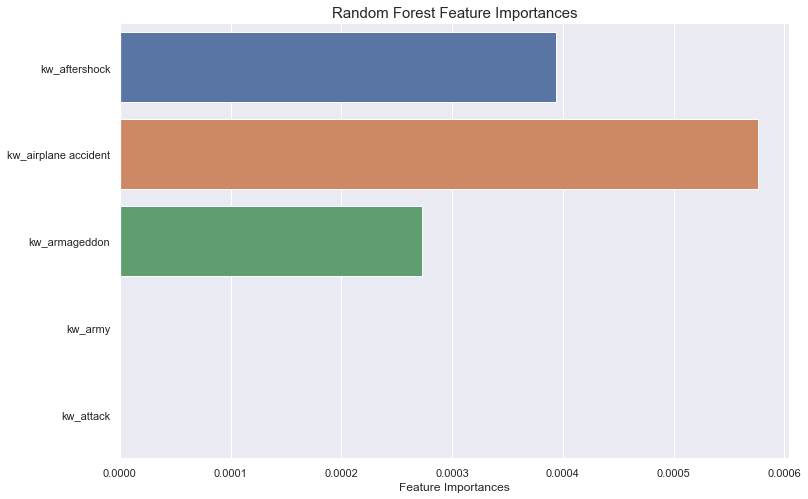

In [1376]:
model_name="Random Forest"
f_imp = pd.DataFrame({"Feature Importances": grid_rfc.best_estimator_.feature_importances_[0:5]}, index=label_bog_final[0:5])

plt.figure(figsize=(12,8))
sns.barplot(x=f_imp["Feature Importances"], y=f_imp.index)
plt.title(f"{model_name} Feature Importances", size=15)
plt.show()

In [1288]:
f_importances(grid_rfc.best_estimator_, "Random Forest", X_train_tfidf_final)

AttributeError: columns not found

In [1056]:
"""
OLD
grid_rfc = GridSearchCV(RandomForestClassifier(), 
                        param_grid_rfc, 
                        refit=True, 
                        verbose=0, 
                        cv=10, 
                        n_jobs=-1,
                        scoring = "accuracy")
grid_rfc.fit(X_train_tfidf_final, y_train['target'])
print(grid_rfc.best_params_)
print(grid_rfc.score(X_train_tfidf_final_2, y_train['target']))
print(grid_rfc.score(X_test_tfidf_final_2, y_test['target']))
"""

{'max_depth': 10, 'max_features': 3, 'min_samples_leaf': 1, 'min_samples_split': 5, 'n_estimators': 100}
0.6336069915254238
0.9440840284213778


## RNN

In [1219]:
def init_model():
    model = models.Sequential()
    model.add(layers.Masking())

    model.add(layers.LSTM(40, activation='tanh',return_sequences=True))
    model.add(layers.Dropout(0.3))
    model.add(layers.LSTM(60, activation='tanh',return_sequences=True))
    model.add(layers.Dropout(0.3))
    model.add(layers.LSTM(20, activation='tanh',return_sequences=False))
    model.add(layers.Dropout(0.3))
    
    model.add(layers.Dense(64, activation='relu',kernel_regularizer = 'l2'))
    model.add(layers.Dropout(0.3))
    model.add(layers.Dense(12, activation='relu'))
    model.add(layers.Dense(1, activation='sigmoid'))

    model.compile(loss='binary_crossentropy',
                  optimizer='rmsprop',
                  metrics=['accuracy'])
    
    return model

In [1220]:
model = init_model()

In [1223]:
es = callbacks.EarlyStopping(patience=10, restore_best_weights=True)
history = model.fit(X_train_clean_pad, y_train['target'], 
          batch_size = 32,
          epochs=1000,
          validation_split=0.3,
          callbacks=[es]
         )

Epoch 1/1000
166/166 [==============================] - 6s 38ms/step - loss: 0.3944 - accuracy: 0.8371 - val_loss: 0.4952 - val_accuracy: 0.7886
Epoch 2/1000
166/166 [==============================] - 6s 35ms/step - loss: 0.3790 - accuracy: 0.8422 - val_loss: 0.4966 - val_accuracy: 0.7891
Epoch 3/1000
166/166 [==============================] - 6s 39ms/step - loss: 0.3570 - accuracy: 0.8547 - val_loss: 0.5540 - val_accuracy: 0.7904
Epoch 4/1000
166/166 [==============================] - 6s 37ms/step - loss: 0.3380 - accuracy: 0.8606 - val_loss: 0.5142 - val_accuracy: 0.7833
Epoch 5/1000
166/166 [==============================] - 6s 35ms/step - loss: 0.3133 - accuracy: 0.8799 - val_loss: 0.6160 - val_accuracy: 0.7586
Epoch 6/1000
166/166 [==============================] - 6s 36ms/step - loss: 0.2919 - accuracy: 0.8820 - val_loss: 0.6208 - val_accuracy: 0.7846
Epoch 7/1000
166/166 [==============================] - 6s 36ms/step - loss: 0.2742 - accuracy: 0.8965 - val_loss: 0.6027 - val_ac

In [1222]:
res = model.evaluate(X_test_clean_pad, y_test['target'])

102/102 [==============================] - 1s 9ms/step - loss: 0.9863 - accuracy: 0.6660


## BERT

As we want to test this method and we do not have a big computational power we will use a light version of BERT called Small BERT.
The advantage of BERT is that there is a preprocessing model enabling us to simply provide our raw text as input

In [1224]:
# Select our preprocess model
bert_preprocess = "https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3"
# Select our BERT model
bert_encoder = "https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-4_H-512_A-8/1"

In [1283]:
def build_BERT_model():
    # Create Input layer
    text_input = tf.keras.layers.Input(shape=(), dtype=tf.string, name='text')
    # Create Preprocessing layer
    preprocessing_layer = hub.KerasLayer(bert_preprocess, name='preprocessing')
    # Prepare inputs for BERT encoding
    encoder_inputs = preprocessing_layer(text_input)
    # Create BeRT encoding layer
    encoder = hub.KerasLayer(bert_encoder, name='BERT_encoder')
    # Generate outputs of BERT envoding layer
    outputs = encoder(encoder_inputs)
    # Extract the relevant data the neural network part
    net = outputs['pooled_output']
    # Add a Dropout layer
    net = tf.keras.layers.Dropout(0.3, name='Dropout')(net)
    # Add a Dense layer with 64 neurons
    net = tf.keras.layers.Dense(32, activation='relu', name="hidden_layer")(net) 
    # Add a final Dense layer to classify our tweets
    net = tf.keras.layers.Dense(1, activation='sigmoid', name='classifier')(net)
    return tf.keras.Model(text_input, net)

In [1263]:
# Build our model having BERT
BERT_model = build_BERT_model()
BERT_model.summary()

Model: "model_11"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 text (InputLayer)              [(None,)]            0           []                               
                                                                                                  
 preprocessing (KerasLayer)     {'input_word_ids':   0           ['text[0][0]']                   
                                (None, 128),                                                      
                                 'input_type_ids':                                                
                                (None, 128),                                                      
                                 'input_mask': (Non                                               
                                e, 128)}                                                   

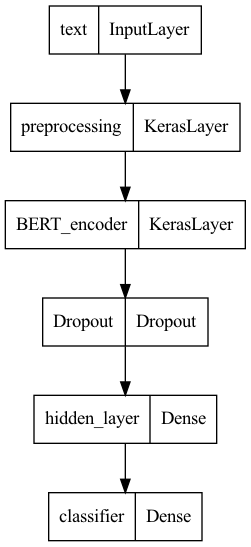

In [1264]:
tf.keras.utils.plot_model(BERT_model)

In [1284]:
# Define the metrics we want to follow
metrics = [
    'accuracy',
    keras.metrics.Recall(),
    keras.metrics.Precision()]

In [1278]:
# Compile our model having BERT 
BERT_model.compile(loss='binary_crossentropy',
                  optimizer='adam',
                  metrics=metrics)

In [1266]:
# Train our model
BERT_es = callbacks.EarlyStopping(patience=10, restore_best_weights=True)
BERT_hitsory = BERT_model.fit(train['text'], y_train['target'], 
          batch_size = 64,
          epochs=100,
          validation_split=0.3,
          callbacks=[BERT_es]
         )

Epoch 1/10


KeyboardInterrupt: 

In [1256]:
# Evaluate on the test set
BERT_res = BERT_model.evaluate(test['text'],y_test['target'])
print(f"Accuracy with this simple model using Small Bert: {BERT_res[1]*100:.02f}%")

102/102 [==============================] - 80s 783ms/step - loss: 0.8529 - accuracy: 0.6206
Accuracy with this simple model using Small Bert: 62.06%


In [1279]:
# Initiate an exponential decay learning rate
initial_learning_rate = 0.005
lr_schedule = ExponentialDecay(initial_learning_rate, 
                               decay_steps = 500, 
                               decay_rate = 0.80)

In [1280]:
# Define new oprtimizer
adam = Adam(learning_rate = lr_schedule)

In [1285]:
# Compile our model with new optimizer 
BERT_model.compile(loss='binary_crossentropy',
                  optimizer=adam,
                  metrics=metrics)

In [1281]:
# Train our model
BERT_es = callbacks.EarlyStopping(patience=10, restore_best_weights=True)
BERT_hitsory_decay = BERT_model.fit(train['text'], y_train['target'], 
          batch_size = 64,
          epochs=10,
          validation_split=0.3,
          callbacks=[BERT_es]
         )

Epoch 1/10
 6/83 [=>............................] - ETA: 2:03 - loss: 0.6644 - accuracy: 0.6276 - recall_1: 0.5263 - precision_1: 0.5921

KeyboardInterrupt: 